<a href="https://colab.research.google.com/github/JairoMillapan/Tarea_4/blob/main/Copia_de_2023_2_UOH_COM4402_Tarea_4_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universidad de O'Higgins

## Escuela de Ingeniería
## COM4402: Introducción a Inteligencia Artificial

### **Tarea 4: Aprendizaje Profundo Avanzado**

### **Autoencoders**

### Estudiante: Jairo Millapán



Un autoencoder es un tipo especial de red neuronal que se entrena para copiar su entrada en su salida. Por ejemplo, dada una imagen de un dígito escrito a mano, un autoencoder primero codifica la imagen en una representación latente de menor dimensión, y luego decodifica la representación latente de vuelta a una imagen. Un autoencoder aprende a comprimir los datos minimizando el error de reconstrucción.

Para saber más sobre los autoencoders, le recomendamos el capítulo 14 de [Deep Learning](https://www.deeplearningbook.org/) de Ian Goodfellow, Yoshua Bengio y Aaron Courville.

## Importar TensorFlow y otras librerías

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Cargar el conjunto de datos
Para empezar, entrenaremos el autoencoder básico utilizando el conjunto de datos Fashion MNIST. Cada imagen de este conjunto de datos tiene 28x28 píxeles.

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


## Primer ejemplo: Autoencoder básico
![Resultados del autoencoder básico](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/intro_autoencoder_result.png?raw=1)

Define un autoencoder con dos capas densas: un `encoder`, que comprime las imágenes en un vector latente de 64 dimensiones, y un `decoder`, que reconstruye la imagen original a partir del espacio latente.

Para definir tu modelo, se utiliza [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models).

In [3]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = x_test.shape[1:]
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)


In [4]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Entrena el modelo utilizando `x_train` como entrada y como objetivo. El `encoder` aprenderá a comprimir el conjunto de datos de 784 dimensiones al espacio latente, y el `decoder` aprenderá a reconstruir las imágenes originales.

In [5]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 20s 5ms/step - loss: 0.0237 - val_loss: 0.0133
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0116 - val_loss: 0.0106
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0101 - val_loss: 0.0098
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0096 - val_loss: 0.0095
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0093 - val_loss: 0.0093
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.00

Ahora que el modelo está entrenado, vamos a probarlo codificando y decodificando imágenes del conjunto de prueba.

In [6]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

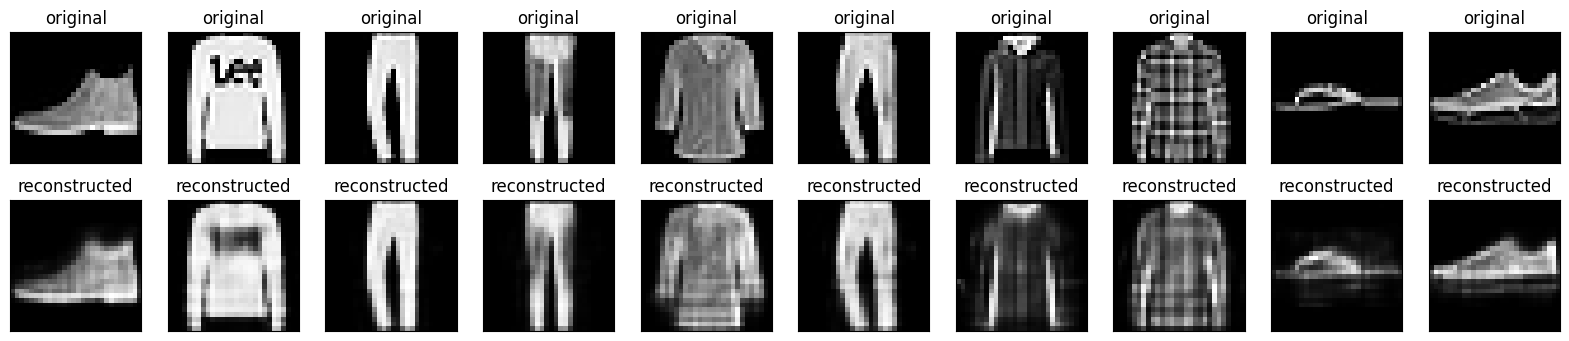

In [7]:
 n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Segundo ejemplo: Eliminación de ruido de imágenes


![Resultados de la eliminación de ruido de imágenes](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/image_denoise_fmnist_results.png?raw=1)

También se puede entrenar un autoencoder para eliminar el ruido de las imágenes. En la siguiente sección, crearás una versión ruidosa del conjunto de datos Fashion MNIST aplicando ruido aleatorio a cada imagen. A continuación, entrenaremos un autoencoder utilizando la imagen ruidosa como entrada y la imagen original como objetivo.

Vamos a reimportar el conjunto de datos para omitir las modificaciones realizadas anteriormente.

In [8]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [9]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


Añadir ruido aleatorio a las imágenes

In [10]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Grafique las imágenes ruidosas.

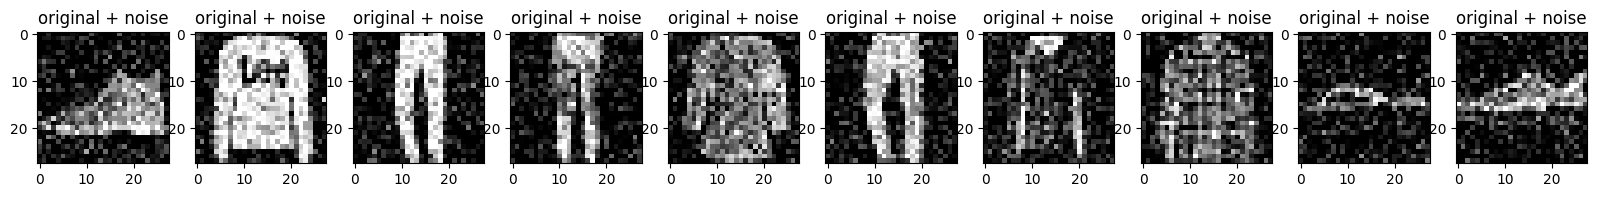

In [11]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### Definir un autoencoder convolucional

En este ejemplo, entrenarás un autoencoder convolucional usando capas [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) en el `encoder`, y capas [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) en el `decoder`.

In [12]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [13]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [14]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 15s 4ms/step - loss: 0.0171 - val_loss: 0.0096
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0090 - val_loss: 0.0086
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0082 - val_loss: 0.0079
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0077 - val_loss: 0.0078
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0070 - val_loss: 0.0069
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 10/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.00

Veamos un resumen del encoder. Observa cómo las imágenes se reducen de 28x28 a 7x7.

In [15]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1320 (5.16 KB)
Trainable params: 1320 (5.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


El decoder aumenta la resolución de las imágenes de 7x7 a 28x28.

In [16]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTr  (None, 14, 14, 8)         584       
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 16)        1168      
 Transpose)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1897 (7.41 KB)
Trainable params: 1897 (7.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Representación gráfica de las imágenes ruidosas y de las imágenes sin ruido producidas por el autoencoder.

In [17]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

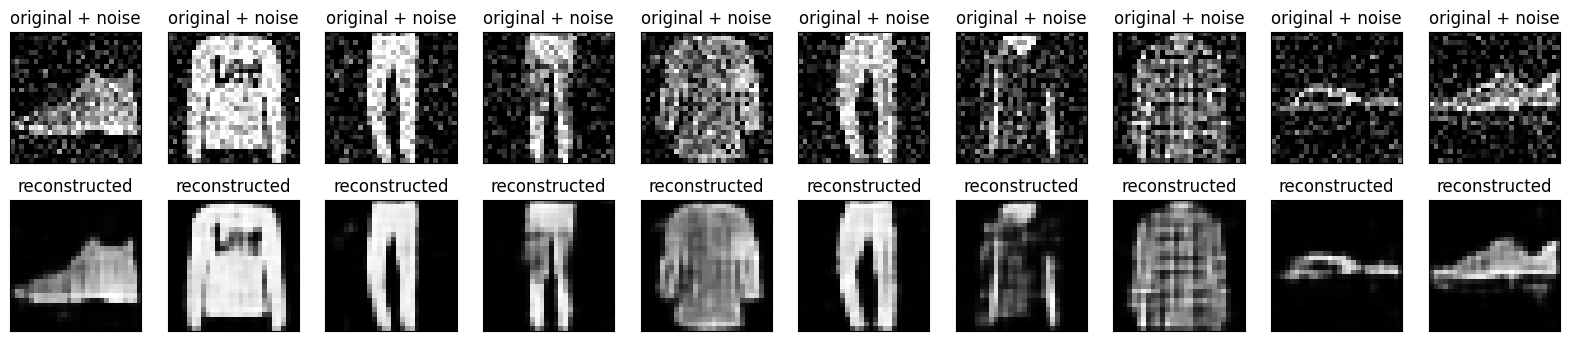

In [18]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()